# Q-Learning Tutorial: 2D Grid Robot Navigation

This notebook provides a simple and intuitive introduction to Q-learning using a 2D grid world where a robot must navigate to reach rewards while avoiding traps.

## Problem Description

We have a robot in a 2D grid world that needs to:
- Start at a specific position
- Navigate to reach reward cells (+10 points)
- Avoid trap cells (-10 points)
- Each step costs -1 point (to encourage shorter paths)
- Find the optimal path to maximize total reward

## Grid World Setup

- **Grid Size**: 5x5
- **Robot**: Starts at position (0, 0)
- **Goal/Reward**: Position (4, 4) gives +10 reward
- **Traps**: Positions (1, 1), (2, 3), (3, 1) give -10 reward
- **Actions**: Up, Down, Left, Right
- **Step Cost**: -1 for each move

## Q-Learning Basics

Q-learning learns the "quality" (Q-value) of taking each action in each state:

**Q-Update Rule**: $Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$

Where:
- $s$: current state (position)
- $a$: action taken
- $s'$: next state
- $r$: immediate reward
- $\alpha$: learning rate (0.1)
- $\gamma$: discount factor (0.9)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

ModuleNotFoundError: No module named 'numpy'

## Environment Setup

Grid World Environment:
- Grid size: 5x5
- Start position: (0, 0)
- Goal position: (4, 4) (reward: +10)
- Trap positions: [(1, 1), (2, 3), (3, 1)] (reward: -10 each)
- Step cost: -1
- Actions: ['Up', 'Down', 'Left', 'Right']


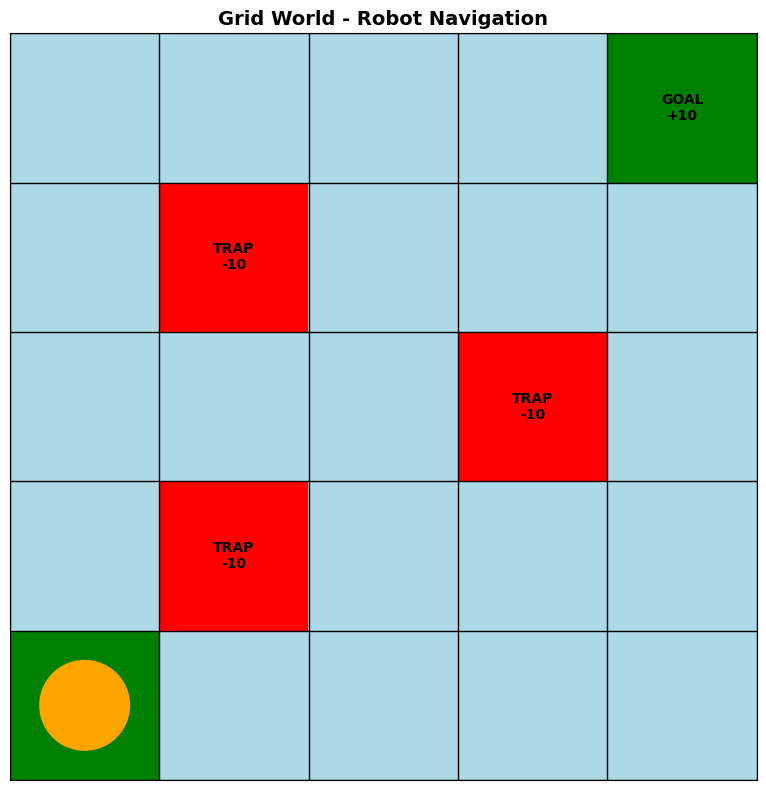

In [ ]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start_pos = (0, 0)
        self.goal_pos = (4, 4)
        self.traps = [(1, 1), (2, 3), (3, 1)]  # Trap positions
        
        # Define rewards
        self.goal_reward = 10
        self.trap_reward = -10
        self.step_reward = -1
        
        # Actions: 0=Up, 1=Down, 2=Left, 3=Right
        self.actions = ['Up', 'Down', 'Left', 'Right']
        self.action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        self.reset()
    
    def reset(self):
        """Reset robot to start position"""
        self.robot_pos = list(self.start_pos)
        return tuple(self.robot_pos)
    
    def is_valid_position(self, pos):
        """Check if position is within grid bounds"""
        row, col = pos
        return 0 <= row < self.size and 0 <= col < self.size
    
    def get_reward(self, pos):
        """Get reward for being in a specific position"""
        if pos == self.goal_pos:
            return self.goal_reward
        elif pos in self.traps:
            return self.trap_reward
        else:
            return self.step_reward
    
    def step(self, action):
        """Take an action and return (next_state, reward, done)"""
        # Calculate new position
        dr, dc = self.action_effects[action]
        new_pos = (self.robot_pos[0] + dr, self.robot_pos[1] + dc)
        
        # Check if new position is valid
        if self.is_valid_position(new_pos):
            self.robot_pos = list(new_pos)
        # If invalid, robot stays in same position
        
        current_pos = tuple(self.robot_pos)
        reward = self.get_reward(current_pos)
        
        # Episode ends if robot reaches goal or trap
        done = (current_pos == self.goal_pos) or (current_pos in self.traps)
        
        return current_pos, reward, done
    
    def visualize(self, q_table=None, show_values=False):
        """Visualize the grid world"""
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
        # Create grid visualization
        grid = np.zeros((self.size, self.size))
        
        # Mark special positions
        for trap in self.traps:
            grid[trap] = -1  # Traps
        grid[self.goal_pos] = 1  # Goal
        grid[self.start_pos] = 0.5  # Start
        
        # Color map: red for traps, green for goal, blue for start, white for empty
        colors = ['red', 'white', 'lightblue', 'green']
        cmap = ListedColormap(colors)
        
        im = ax.imshow(grid, cmap=cmap, vmin=-1, vmax=1)
        
        # Add grid lines
        for i in range(self.size + 1):
            ax.axhline(i - 0.5, color='black', linewidth=1)
            ax.axvline(i - 0.5, color='black', linewidth=1)
        
        # Add labels
        for i in range(self.size):
            for j in range(self.size):
                if (i, j) == self.start_pos:
                    ax.text(j, i, 'START', ha='center', va='center', fontweight='bold')
                elif (i, j) == self.goal_pos:
                    ax.text(j, i, 'GOAL\n+10', ha='center', va='center', fontweight='bold')
                elif (i, j) in self.traps:
                    ax.text(j, i, 'TRAP\n-10', ha='center', va='center', fontweight='bold')
                elif show_values and q_table is not None:
                    # Show best action value
                    max_q = np.max(q_table[i, j])
                    ax.text(j, i, f'{max_q:.1f}', ha='center', va='center', fontsize=10)
        
        # Add robot position
        robot_circle = plt.Circle((self.robot_pos[1], self.robot_pos[0]), 0.3, 
                                color='orange', zorder=5)
        ax.add_patch(robot_circle)
        
        ax.set_xlim(-0.5, self.size - 0.5)
        ax.set_ylim(-0.5, self.size - 0.5)
        ax.set_aspect('equal')
        ax.set_title('Grid World - Robot Navigation', fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.tight_layout()
        plt.show()

# Create and visualize the environment
env = GridWorld()
print("Grid World Environment:")
print(f"- Grid size: {env.size}x{env.size}")
print(f"- Start position: {env.start_pos}")
print(f"- Goal position: {env.goal_pos} (reward: +{env.goal_reward})")
print(f"- Trap positions: {env.traps} (reward: {env.trap_reward} each)")
print(f"- Step cost: {env.step_reward}")
print(f"- Actions: {env.actions}")

env.visualize()

## Q-Learning Implementation

In [ ]:
class QLearningAgent:
    def __init__(self, grid_size, n_actions, learning_rate=0.1, discount_factor=0.9, epsilon=1.0):
        self.grid_size = grid_size
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        
        # Initialize Q-table with zeros
        # Shape: (grid_size, grid_size, n_actions)
        self.q_table = np.zeros((grid_size, grid_size, n_actions))
        
        # Tracking for visualization and analysis
        self.q_history = []  # Store Q-table snapshots
        self.epsilon_history = []  # Track epsilon values
        self.q_updates = []  # Store Q-update examples
        self.action_counts = {'explore': 0, 'exploit': 0}  # Count exploration vs exploitation
    
    def choose_action(self, state, track_policy=False):
        """Choose action using epsilon-greedy policy"""
        explore = random.random() < self.epsilon
        
        if explore:
            # Explore: choose random action
            action = random.randint(0, self.n_actions - 1)
            if track_policy:
                self.action_counts['explore'] += 1
        else:
            # Exploit: choose best action
            row, col = state
            action = np.argmax(self.q_table[row, col])
            if track_policy:
                self.action_counts['exploit'] += 1
        
        if track_policy:
            return action, explore
        else:
            return action
    
    def update_q_table(self, state, action, reward, next_state, done, track_update=False):
        """Update Q-table using Q-learning update rule"""
        row, col = state
        next_row, next_col = next_state
        
        # Current Q-value
        current_q = self.q_table[row, col, action]
        
        # Maximum Q-value for next state (0 if terminal state)
        if done:
            max_next_q = 0
        else:
            max_next_q = np.max(self.q_table[next_row, next_col])
        
        # Q-learning update rule
        td_target = reward + self.discount_factor * max_next_q
        td_error = td_target - current_q
        new_q = current_q + self.learning_rate * td_error
        
        # Store update information for tracking
        if track_update:
            update_info = {
                'state': state,
                'action': action,
                'reward': reward,
                'next_state': next_state,
                'current_q': current_q,
                'max_next_q': max_next_q,
                'td_target': td_target,
                'td_error': td_error,
                'new_q': new_q,
                'done': done
            }
            self.q_updates.append(update_info)
        
        self.q_table[row, col, action] = new_q
    
    def decay_epsilon(self, decay_rate=0.995, min_epsilon=0.01):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon * decay_rate, min_epsilon)
        self.epsilon_history.append(self.epsilon)
    
    def save_q_snapshot(self, episode):
        """Save a snapshot of the current Q-table"""
        self.q_history.append({
            'episode': episode,
            'q_table': self.q_table.copy(),
            'epsilon': self.epsilon
        })
    
    def get_policy(self):
        """Get the learned policy (best action for each state)"""
        policy = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                policy[i, j] = np.argmax(self.q_table[i, j])
        return policy

# Initialize the Q-learning agent
agent = QLearningAgent(grid_size=5, n_actions=4, learning_rate=0.1, discount_factor=0.9, epsilon=1.0)

print("Enhanced Q-Learning Agent initialized:")
print(f"- Grid size: {agent.grid_size}x{agent.grid_size}")
print(f"- Number of actions: {agent.n_actions}")
print(f"- Learning rate (α): {agent.learning_rate}")
print(f"- Discount factor (γ): {agent.discount_factor}")
print(f"- Initial exploration rate (ε): {agent.epsilon}")
print(f"- Q-table shape: {agent.q_table.shape}")
print("- Enhanced with tracking for Q-evolution, epsilon policy, and Q-updates")

Enhanced Q-Learning Agent initialized:
- Grid size: 5x5
- Number of actions: 4
- Learning rate (α): 0.1
- Discount factor (γ): 0.9
- Initial exploration rate (ε): 1.0
- Q-table shape: (5, 5, 4)
- Enhanced with tracking for Q-evolution, epsilon policy, and Q-updates


## Training the Agent

## Understanding Epsilon-Greedy Policy

Before training, let's understand how the epsilon-greedy policy works in action selection.

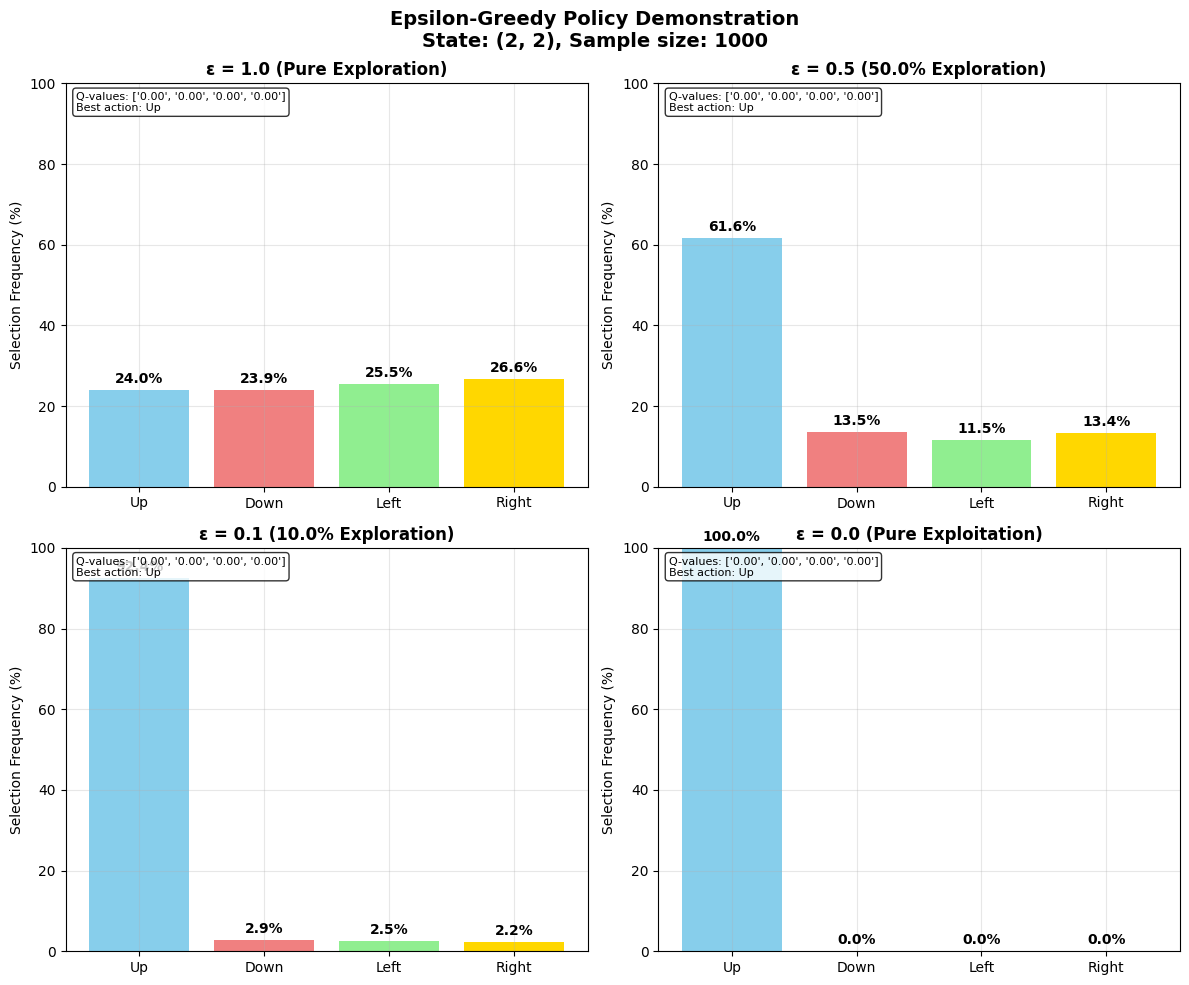

Epsilon-Greedy Policy Explanation:
• ε = 1.0: Pure exploration - all actions chosen randomly (25% each)
• ε = 0.5: 50% exploration, 50% exploitation
• ε = 0.1: 10% exploration, 90% exploitation
• ε = 0.0: Pure exploitation - always choose best action

This balance allows the agent to:
1. Explore new actions early in training (high ε)
2. Gradually shift to exploiting learned knowledge (decreasing ε)
3. Maintain some exploration to handle environment changes


In [ ]:
def demonstrate_epsilon_greedy_policy(agent, state=(2, 2), n_samples=1000):
    """Demonstrate epsilon-greedy policy in action"""
    
    # Test with different epsilon values
    epsilon_values = [1.0, 0.5, 0.1, 0.0]
    
    fig, axes = plt.subplots(2, 2, figsize=(6, 5))
    axes = axes.flatten()
    
    action_names = ['Up', 'Down', 'Left', 'Right']
    
    for idx, epsilon_test in enumerate(epsilon_values):
        # Temporarily change epsilon
        original_epsilon = agent.epsilon
        agent.epsilon = epsilon_test
        
        # Count actions taken
        action_counts = {i: 0 for i in range(4)}
        
        for _ in range(n_samples):
            action = agent.choose_action(state)
            action_counts[action] += 1
        
        # Restore original epsilon
        agent.epsilon = original_epsilon
        
        # Plot results
        ax = axes[idx]
        actions = list(action_counts.keys())
        counts = [action_counts[i] for i in actions]
        percentages = [count/n_samples*100 for count in counts]
        
        bars = ax.bar([action_names[i] for i in actions], percentages, 
                     color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        
        # Add percentage labels on bars
        for bar, pct in zip(bars, percentages):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax.set_title(f'ε = {epsilon_test} ({"Pure Exploration" if epsilon_test == 1.0 else "Pure Exploitation" if epsilon_test == 0.0 else f"{epsilon_test*100}% Exploration"})', 
                    fontweight='bold')
        ax.set_ylabel('Selection Frequency (%)')
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.3)
        
        # Show Q-values for reference
        row, col = state
        q_vals = agent.q_table[row, col]
        best_action = np.argmax(q_vals)
        ax.text(0.02, 0.98, f'Q-values: {[f"{q:.2f}" for q in q_vals]}\nBest action: {action_names[best_action]}', 
               transform=ax.transAxes, verticalalignment='top', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(f'Epsilon-Greedy Policy Demonstration\nState: {state}, Sample size: {n_samples}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Epsilon-Greedy Policy Explanation:")
    print("• ε = 1.0: Pure exploration - all actions chosen randomly (25% each)")
    print("• ε = 0.5: 50% exploration, 50% exploitation")
    print("• ε = 0.1: 10% exploration, 90% exploitation")
    print("• ε = 0.0: Pure exploitation - always choose best action")
    print()
    print("This balance allows the agent to:")
    print("1. Explore new actions early in training (high ε)")
    print("2. Gradually shift to exploiting learned knowledge (decreasing ε)")
    print("3. Maintain some exploration to handle environment changes")

# Demonstrate epsilon-greedy policy
demonstrate_epsilon_greedy_policy(agent)

In [ ]:
# Training parameters
n_episodes = 1000
max_steps_per_episode = 50

# Track training progress
episode_rewards = []
episode_lengths = []
success_rate = []

# Episodes at which to save Q-table snapshots for evolution visualization
snapshot_episodes = [0, 10, 50, 100, 200, 500, 999]

print("Starting Q-learning training...")
print(f"Episodes: {n_episodes}, Max steps per episode: {max_steps_per_episode}")
print(f"Tracking Q-evolution at episodes: {snapshot_episodes}")
print()

for episode in range(n_episodes):
    # Reset environment
    state = env.reset()
    total_reward = 0
    steps = 0
    
    # Reset action counts for this episode
    agent.action_counts = {'explore': 0, 'exploit': 0}
    
    for step in range(max_steps_per_episode):
        # Choose action (track policy for first few episodes)
        track_policy = episode < 5
        if track_policy:
            action, explored = agent.choose_action(state, track_policy=True)
        else:
            action = agent.choose_action(state)
        
        # Take action
        next_state, reward, done = env.step(action)
        
        # Update Q-table (track updates for first few episodes)
        track_update = episode < 3 and len(agent.q_updates) < 20
        agent.update_q_table(state, action, reward, next_state, done, track_update=track_update)
        
        # Update tracking variables
        state = next_state
        total_reward += reward
        steps += 1
        
        if done:
            break
    
    # Decay exploration rate
    agent.decay_epsilon()
    
    # Save Q-table snapshot at specific episodes
    if episode in snapshot_episodes:
        agent.save_q_snapshot(episode)
    
    # Record episode statistics
    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    
    # Calculate success rate (reaching goal) over last 100 episodes
    if episode >= 99:
        recent_rewards = episode_rewards[-100:]
        successes = sum(1 for r in recent_rewards if r > 0)  # Positive reward means reached goal
        success_rate.append(successes / 100.0)
    
    # Print progress with epsilon-greedy policy info for first few episodes
    if episode < 5:
        explore_pct = agent.action_counts['explore'] / (agent.action_counts['explore'] + agent.action_counts['exploit']) * 100
        print(f"Episode {episode + 1:2d}: Reward = {total_reward:6.1f}, Steps = {steps:2d}, "
              f"ε = {agent.epsilon:.3f}, Explore = {explore_pct:.1f}% ({agent.action_counts['explore']}/{agent.action_counts['explore'] + agent.action_counts['exploit']} actions)")
    elif (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        avg_length = np.mean(episode_lengths[-100:])
        current_success_rate = success_rate[-1] if success_rate else 0
        print(f"Episode {episode + 1:4d}: Avg Reward = {avg_reward:6.2f}, "
              f"Avg Length = {avg_length:5.1f}, Success Rate = {current_success_rate:.2%}, "
              f"ε = {agent.epsilon:.3f}")

print("\nTraining completed!")
print(f"Total Q-table snapshots saved: {len(agent.q_history)}")
print(f"Q-update examples tracked: {len(agent.q_updates)}")
print(f"Epsilon decay history length: {len(agent.epsilon_history)}")

Starting Q-learning training...
Episodes: 1000, Max steps per episode: 50
Tracking Q-evolution at episodes: [0, 10, 50, 100, 200, 500, 999]

Episode  1: Reward =  -21.0, Steps = 12, ε = 0.995, Explore = 100.0% (12/12 actions)
Episode  2: Reward =  -18.0, Steps =  9, ε = 0.990, Explore = 100.0% (9/9 actions)
Episode  3: Reward =  -28.0, Steps = 19, ε = 0.985, Explore = 100.0% (19/19 actions)
Episode  4: Reward =  -11.0, Steps =  2, ε = 0.980, Explore = 100.0% (2/2 actions)
Episode  5: Reward =  -11.0, Steps =  2, ε = 0.975, Explore = 100.0% (2/2 actions)
Episode  100: Avg Reward = -19.21, Avg Length =  11.7, Success Rate = 0.00%, ε = 0.606
Episode  200: Avg Reward = -11.81, Avg Length =   9.8, Success Rate = 9.00%, ε = 0.367
Episode  300: Avg Reward =  -5.07, Avg Length =   9.1, Success Rate = 45.00%, ε = 0.222
Episode  400: Avg Reward =  -0.87, Avg Length =   8.3, Success Rate = 76.00%, ε = 0.135
Episode  500: Avg Reward =   1.15, Avg Length =   8.1, Success Rate = 87.00%, ε = 0.082
Ep

## Visualizing Training Progress

## Q-Update Examples During Training

Let's examine specific Q-value updates that occurred during the first few episodes to understand how the agent learns.

In [ ]:
def display_q_updates(agent, max_updates=10):
    """Display detailed Q-update examples from training"""
    
    if not agent.q_updates:
        print("No Q-updates were tracked during training.")
        return
    
    print("🔍 Q-Learning Update Examples")
    print("=" * 70)
    print("Q-Update Rule: Q(s,a) ← Q(s,a) + α[r + γ⋅max Q(s',a') - Q(s,a)]")
    print(f"Parameters: α = {agent.learning_rate}, γ = {agent.discount_factor}")
    print("=" * 70)
    
    action_names = ['Up', 'Down', 'Left', 'Right']
    
    for i, update in enumerate(agent.q_updates[:max_updates]):
        print(f"\n📍 Update #{i+1}:")
        print(f"   State: {update['state']} → Action: {action_names[update['action']]} → Next State: {update['next_state']}")
        print(f"   Reward: {update['reward']}")
        print(f"   Terminal: {'Yes' if update['done'] else 'No'}")
        
        print(f"\n   🧮 Calculation Details:")
        print(f"   • Current Q(s,a) = {update['current_q']:.3f}")
        print(f"   • Reward (r) = {update['reward']}")
        if update['done']:
            print(f"   • max Q(s',a') = 0 (terminal state)")
        else:
            print(f"   • max Q(s',a') = {update['max_next_q']:.3f}")
        print(f"   • TD Target = r + γ⋅max Q(s',a') = {update['reward']} + {agent.discount_factor}×{update['max_next_q']:.3f} = {update['td_target']:.3f}")
        print(f"   • TD Error = {update['td_target']:.3f} - {update['current_q']:.3f} = {update['td_error']:.3f}")
        print(f"   • New Q(s,a) = {update['current_q']:.3f} + {agent.learning_rate}×{update['td_error']:.3f} = {update['new_q']:.3f}")
        
        change = update['new_q'] - update['current_q']
        direction = "↗️" if change > 0 else "↘️" if change < 0 else "➡️"
        print(f"   • Change: {change:+.3f} {direction}")
        print("-" * 50)

# Display Q-update examples
display_q_updates(agent, max_updates=8)

🔍 Q-Learning Update Examples
Q-Update Rule: Q(s,a) ← Q(s,a) + α[r + γ⋅max Q(s',a') - Q(s,a)]
Parameters: α = 0.1, γ = 0.9

📍 Update #1:
   State: (0, 0) → Action: Up → Next State: (0, 0)
   Reward: -1
   Terminal: No

   🧮 Calculation Details:
   • Current Q(s,a) = 0.000
   • Reward (r) = -1
   • max Q(s',a') = 0.000
   • TD Target = r + γ⋅max Q(s',a') = -1 + 0.9×0.000 = -1.000
   • TD Error = -1.000 - 0.000 = -1.000
   • New Q(s,a) = 0.000 + 0.1×-1.000 = -0.100
   • Change: -0.100 ↘️
--------------------------------------------------

📍 Update #2:
   State: (0, 0) → Action: Left → Next State: (0, 0)
   Reward: -1
   Terminal: No

   🧮 Calculation Details:
   • Current Q(s,a) = 0.000
   • Reward (r) = -1
   • max Q(s',a') = 0.000
   • TD Target = r + γ⋅max Q(s',a') = -1 + 0.9×0.000 = -1.000
   • TD Error = -1.000 - 0.000 = -1.000
   • New Q(s,a) = 0.000 + 0.1×-1.000 = -0.100
   • Change: -0.100 ↘️
--------------------------------------------------

📍 Update #3:
   State: (0, 0) → Actio

## Q-Function Evolution During Training

Watch how the Q-values evolve from random initialization to learned optimal values.

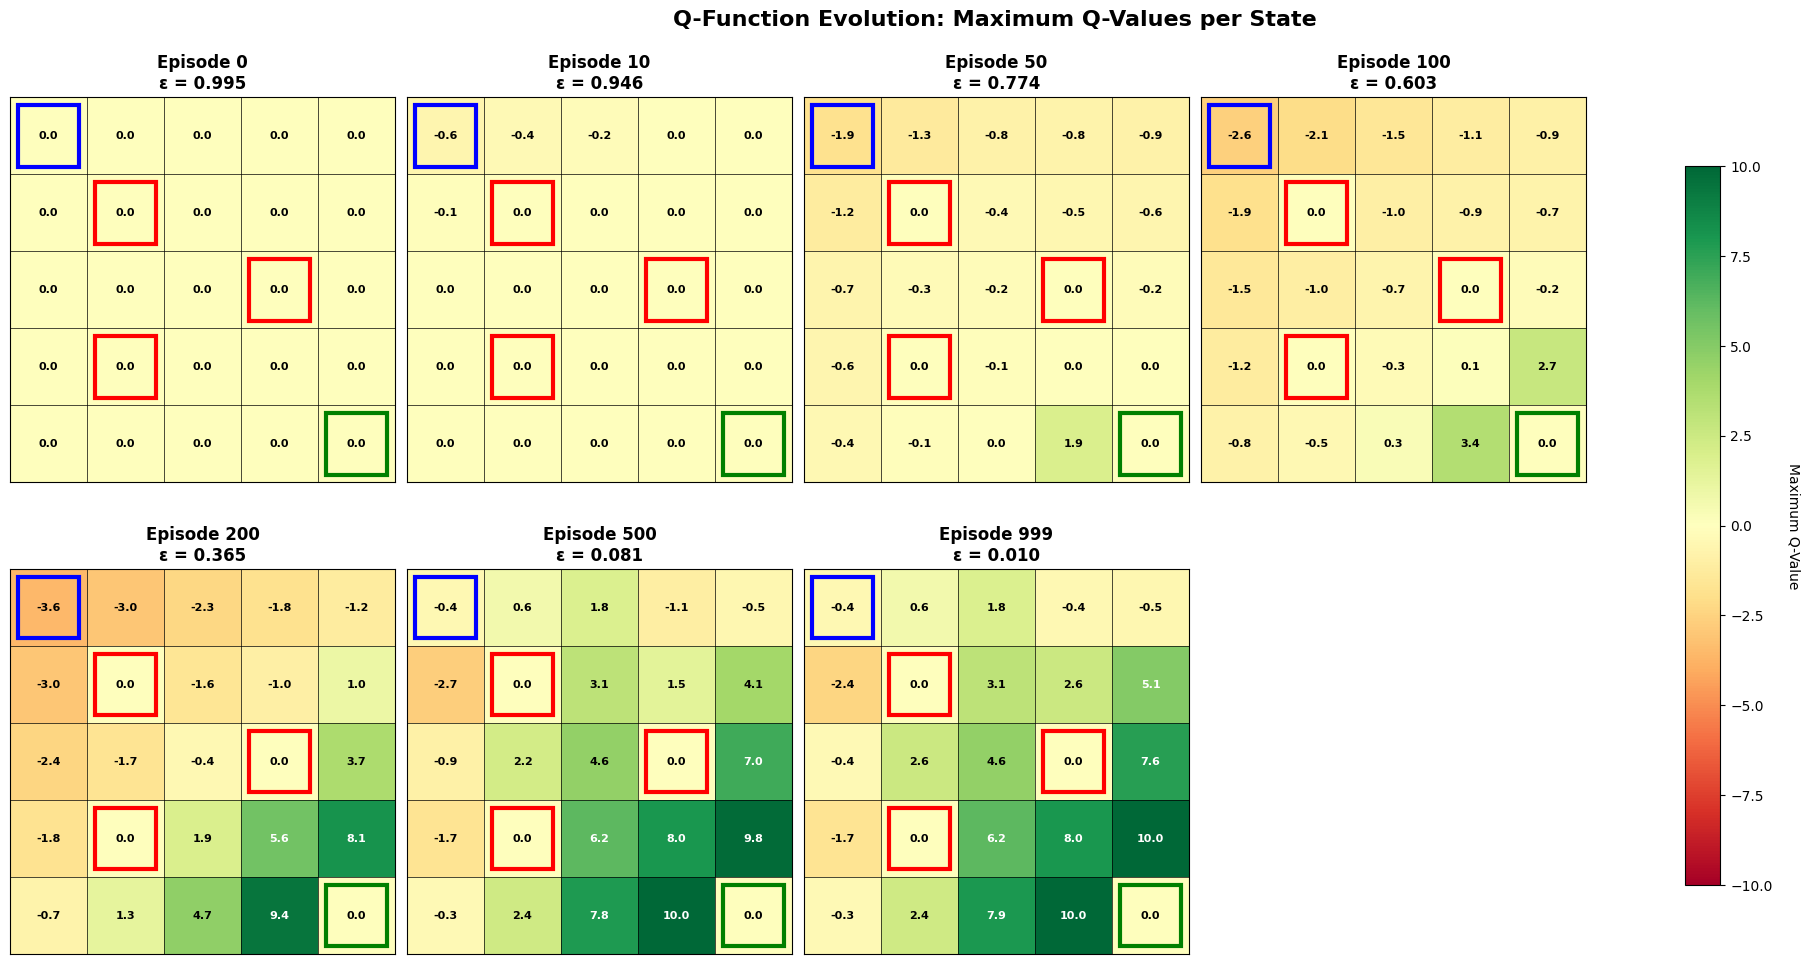

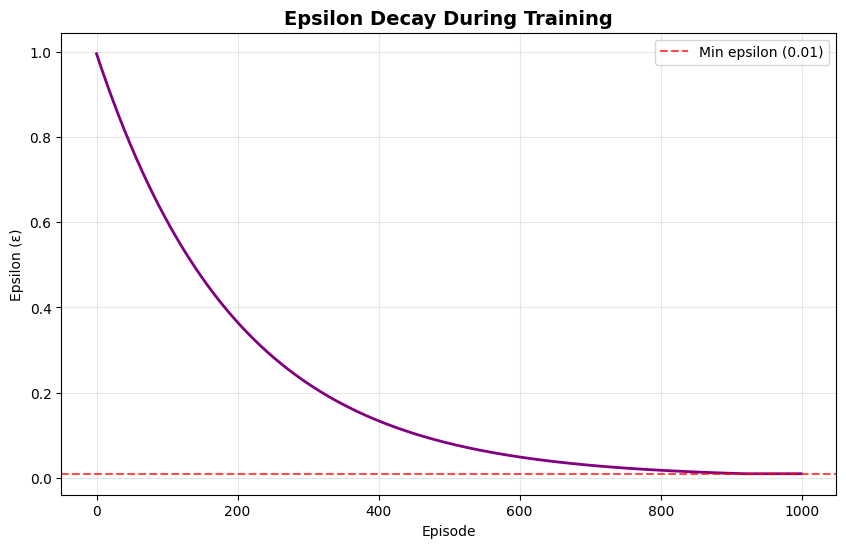

🎯 Q-Function Evolution Insights:
• Started with all zeros (Episode 0)
• Gradually learned state values through experience
• Goal state area shows high positive values (green)
• Trap areas show negative values (red)
• Epsilon decayed from 0.995 to 0.010
• Values stabilized as exploration decreased


In [ ]:
def visualize_q_evolution(agent, env):
    """Visualize the evolution of Q-values during training"""
    
    if not agent.q_history:
        print("No Q-table snapshots were saved during training.")
        return
    
    n_snapshots = len(agent.q_history)
    action_names = ['Up', 'Down', 'Left', 'Right']
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    for idx, snapshot in enumerate(agent.q_history[:8]):  # Show up to 8 snapshots
        row = idx // 4
        col = idx % 4
        ax = axes[row, col]
        
        # Calculate maximum Q-values for each state
        max_q_values = np.max(snapshot['q_table'], axis=2)
        
        # Create heatmap
        im = ax.imshow(max_q_values, cmap='RdYlGn', aspect='equal', vmin=-10, vmax=10)
        
        # Add grid lines
        for i in range(env.size + 1):
            ax.axhline(i - 0.5, color='black', linewidth=0.5)
            ax.axvline(i - 0.5, color='black', linewidth=0.5)
        
        # Mark special positions
        ax.add_patch(Rectangle((env.start_pos[1]-0.4, env.start_pos[0]-0.4), 0.8, 0.8, 
                              fill=False, edgecolor='blue', linewidth=3))
        ax.add_patch(Rectangle((env.goal_pos[1]-0.4, env.goal_pos[0]-0.4), 0.8, 0.8, 
                              fill=False, edgecolor='green', linewidth=3))
        for trap in env.traps:
            ax.add_patch(Rectangle((trap[1]-0.4, trap[0]-0.4), 0.8, 0.8, 
                                  fill=False, edgecolor='red', linewidth=3))
        
        # Add Q-values as text
        for i in range(env.size):
            for j in range(env.size):
                value = max_q_values[i, j]
                color = 'white' if abs(value) > 5 else 'black'
                ax.text(j, i, f'{value:.1f}', ha='center', va='center', 
                       color=color, fontweight='bold', fontsize=8)
        
        ax.set_title(f'Episode {snapshot["episode"]}\nε = {snapshot["epsilon"]:.3f}', 
                    fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide unused subplots
    for idx in range(len(agent.q_history), 8):
        row = idx // 4
        col = idx % 4
        axes[row, col].set_visible(False)
    
    plt.suptitle('Q-Function Evolution: Maximum Q-Values per State', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=axes, shrink=0.8, aspect=20)
    cbar.set_label('Maximum Q-Value', rotation=270, labelpad=20)
    
    plt.show()
    
    # Show epsilon decay
    plt.figure(figsize=(10, 6))
    plt.plot(agent.epsilon_history, linewidth=2, color='purple')
    plt.title('Epsilon Decay During Training', fontsize=14, fontweight='bold')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon (ε)')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0.01, color='red', linestyle='--', alpha=0.7, label='Min epsilon (0.01)')
    plt.legend()
    plt.show()
    
    print("🎯 Q-Function Evolution Insights:")
    print(f"• Started with all zeros (Episode 0)")
    print(f"• Gradually learned state values through experience")
    print(f"• Goal state area shows high positive values (green)")
    print(f"• Trap areas show negative values (red)")
    print(f"• Epsilon decayed from {agent.q_history[0]['epsilon']:.3f} to {agent.q_history[-1]['epsilon']:.3f}")
    print(f"• Values stabilized as exploration decreased")

# Visualize Q-function evolution
visualize_q_evolution(agent, env)

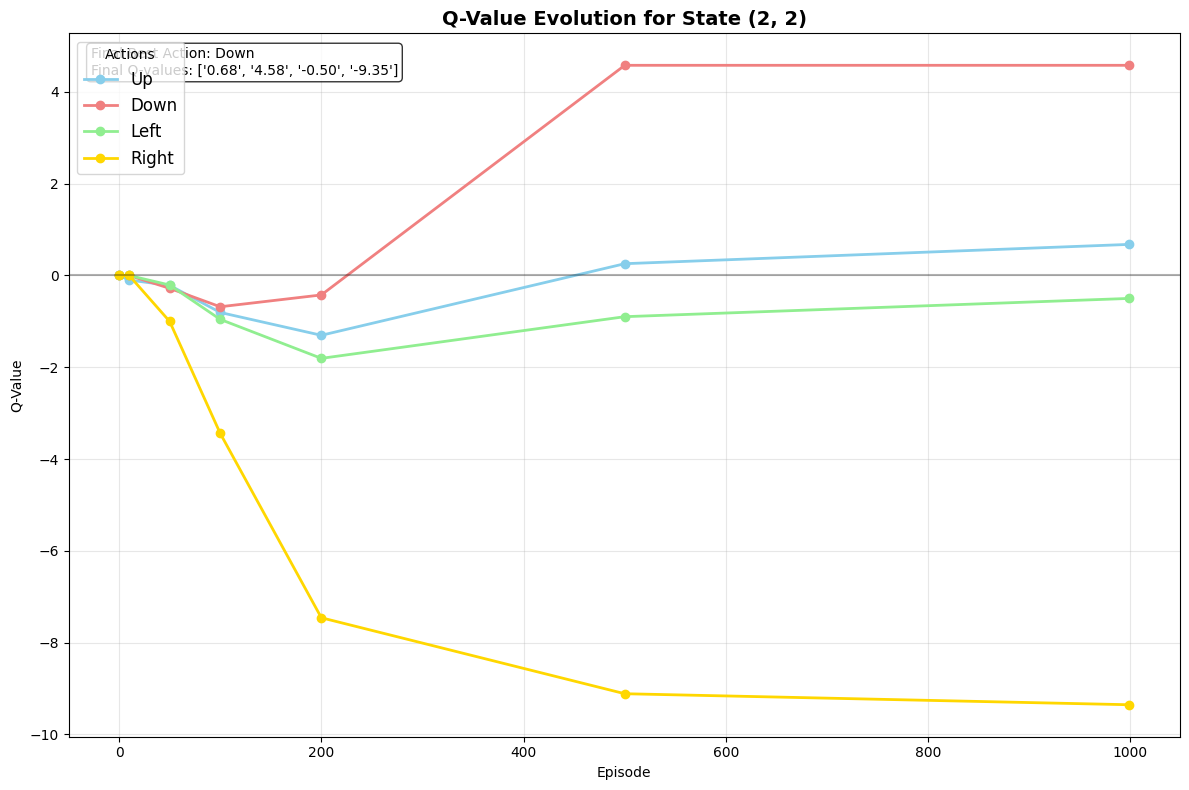


📊 Q-Value Evolution Summary for State (2, 2)
Episode    Up       Down     Left     Right    Best Action
------------------------------------------------------------
0          0.00     0.00     0.00     0.00     Up
10         -0.10    0.00     0.00     0.00     Down
50         -0.21    -0.28    -0.21    -1.00    Left
100        -0.81    -0.68    -0.96    -3.44    Down
200        -1.30    -0.42    -1.81    -7.46    Down
500        0.26     4.58     -0.90    -9.11    Down
999        0.68     4.58     -0.50    -9.35    Down


In [ ]:
def visualize_action_q_evolution(agent, state=(2, 2)):
    """Visualize how Q-values for each action evolve at a specific state"""
    
    if not agent.q_history:
        print("No Q-table snapshots were saved during training.")
        return
    
    action_names = ['Up', 'Down', 'Left', 'Right']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    
    # Extract Q-values for the specific state across episodes
    episodes = [snapshot['episode'] for snapshot in agent.q_history]
    q_evolution = {action: [] for action in range(4)}
    
    for snapshot in agent.q_history:
        row, col = state
        for action in range(4):
            q_evolution[action].append(snapshot['q_table'][row, col, action])
    
    # Create the plot
    plt.figure(figsize=(6, 4))
    
    for action in range(4):
        plt.plot(episodes, q_evolution[action], marker='o', linewidth=2, 
                color=colors[action], label=f'{action_names[action]}', markersize=6)
    
    plt.title(f'Q-Value Evolution for State {state}', fontsize=14, fontweight='bold')
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(title='Actions', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add annotations for key insights
    final_q_values = [q_evolution[action][-1] for action in range(4)]
    best_action = np.argmax(final_q_values)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.text(0.02, 0.98, f'Final Best Action: {action_names[best_action]}\nFinal Q-values: {[f"{q:.2f}" for q in final_q_values]}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Show a comparison table
    print(f"\n📊 Q-Value Evolution Summary for State {state}")
    print("=" * 60)
    print(f"{'Episode':<10} {'Up':<8} {'Down':<8} {'Left':<8} {'Right':<8} {'Best Action'}")
    print("-" * 60)
    
    for i, episode in enumerate(episodes):
        q_vals = [q_evolution[action][i] for action in range(4)]
        best_action_idx = np.argmax(q_vals)
        print(f"{episode:<10} {q_vals[0]:<8.2f} {q_vals[1]:<8.2f} {q_vals[2]:<8.2f} {q_vals[3]:<8.2f} {action_names[best_action_idx]}")

# Show action-specific Q-value evolution for a central state
visualize_action_q_evolution(agent, state=(2, 2))

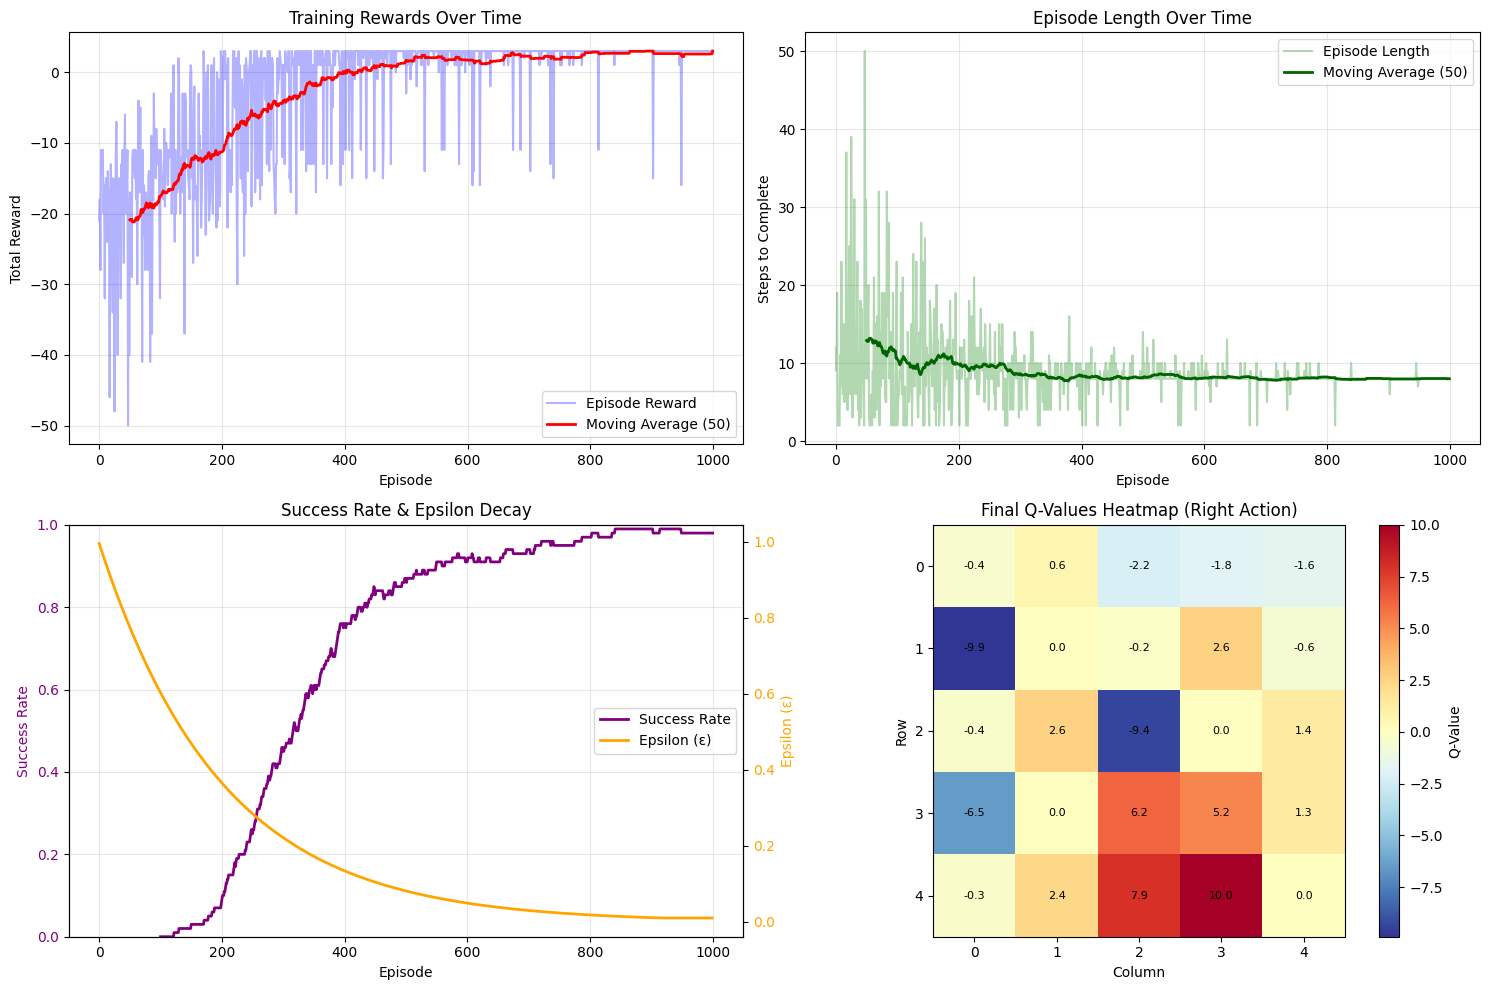

Enhanced Training Statistics:
- Total episodes: 1000
- Average reward (last 100 episodes): 2.61
- Average episode length (last 100 episodes): 8.0 steps
- Final success rate: 98.00%
- Final exploration rate (ε): 0.010
- Epsilon decay: 0.995 → 0.010
- Q-updates tracked: 20
- Q-table snapshots saved: 7


In [ ]:
# Create enhanced training progress plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5))

# Plot 1: Episode rewards
ax1.plot(episode_rewards, alpha=0.3, color='blue', label='Episode Reward')
# Moving average
if len(episode_rewards) > 50:
    moving_avg = []
    window = 50
    for i in range(window, len(episode_rewards)):
        moving_avg.append(np.mean(episode_rewards[i-window:i]))
    ax1.plot(range(window, len(episode_rewards)), moving_avg, color='red', linewidth=2, label='Moving Average (50)')

ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Rewards Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Episode lengths
ax2.plot(episode_lengths, alpha=0.3, color='green', label='Episode Length')
# Moving average
if len(episode_lengths) > 50:
    moving_avg_length = []
    for i in range(window, len(episode_lengths)):
        moving_avg_length.append(np.mean(episode_lengths[i-window:i]))
    ax2.plot(range(window, len(episode_lengths)), moving_avg_length, color='darkgreen', linewidth=2, label='Moving Average (50)')

ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps to Complete')
ax2.set_title('Episode Length Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Success rate and epsilon decay
ax3_twin = ax3.twinx()

# Success rate
if success_rate:
    line1 = ax3.plot(range(100, 100 + len(success_rate)), success_rate, color='purple', linewidth=2, label='Success Rate')
    ax3.set_ylabel('Success Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

# Epsilon decay
if agent.epsilon_history:
    line2 = ax3_twin.plot(range(len(agent.epsilon_history)), agent.epsilon_history, color='orange', linewidth=2, label='Epsilon (ε)')
    ax3_twin.set_ylabel('Epsilon (ε)', color='orange')
    ax3_twin.tick_params(axis='y', labelcolor='orange')

ax3.set_xlabel('Episode')
ax3.set_title('Success Rate & Epsilon Decay')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Plot 4: Q-values heatmap for one action (Right action)
im = ax4.imshow(agent.q_table[:, :, 3], cmap='RdYlBu_r', aspect='equal')
ax4.set_title('Final Q-Values Heatmap (Right Action)')
ax4.set_xlabel('Column')
ax4.set_ylabel('Row')

# Add text annotations for Q-values
for i in range(agent.grid_size):
    for j in range(agent.grid_size):
        text = ax4.text(j, i, f'{agent.q_table[i, j, 3]:.1f}', 
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()

# Add colorbar for the heatmap
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Q-Value')

plt.show()

# Print enhanced final statistics
print("Enhanced Training Statistics:")
print(f"- Total episodes: {len(episode_rewards)}")
print(f"- Average reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.2f}")
print(f"- Average episode length (last 100 episodes): {np.mean(episode_lengths[-100:]):.1f} steps")
if success_rate:
    print(f"- Final success rate: {success_rate[-1]:.2%}")
print(f"- Final exploration rate (ε): {agent.epsilon:.3f}")
print(f"- Epsilon decay: {agent.epsilon_history[0]:.3f} → {agent.epsilon_history[-1]:.3f}")
print(f"- Q-updates tracked: {len(agent.q_updates)}")
print(f"- Q-table snapshots saved: {len(agent.q_history)}")

## Visualizing the Learned Policy

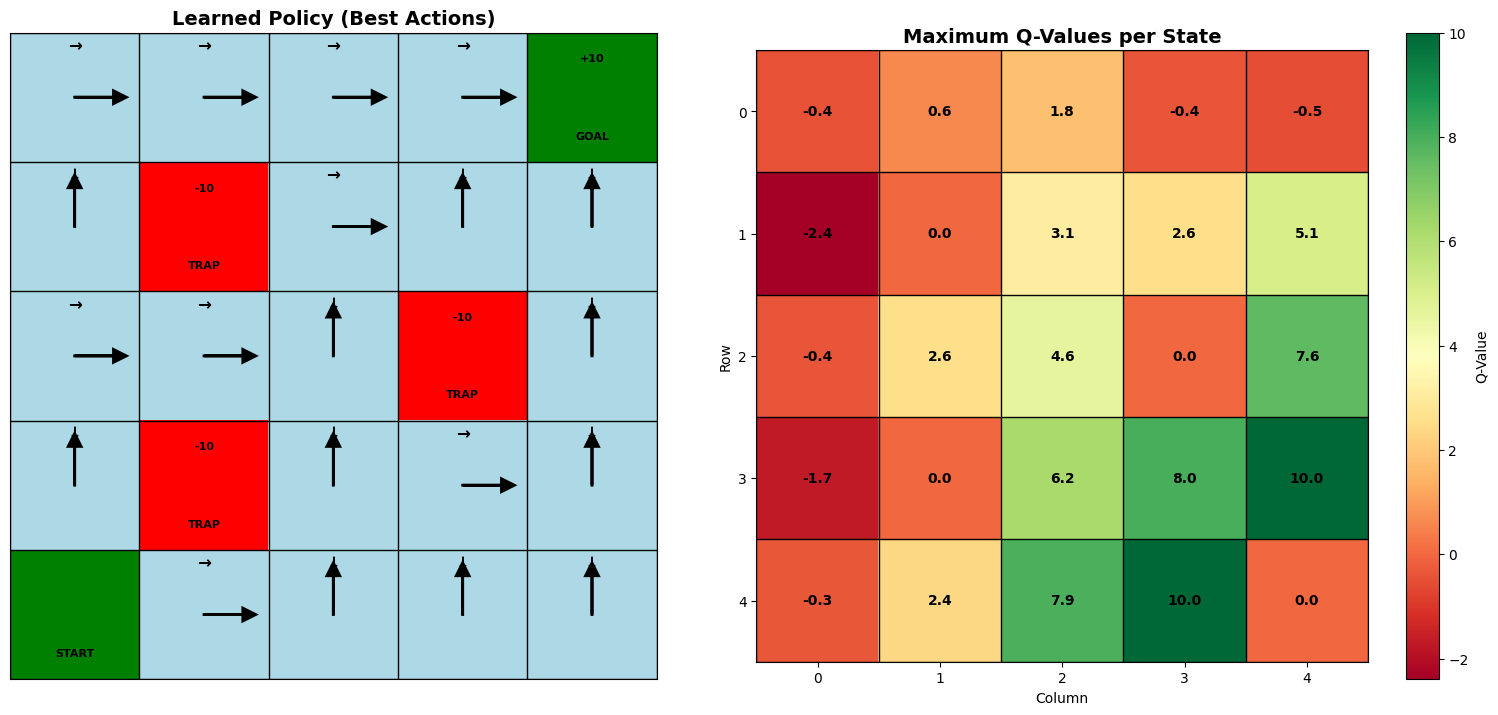

Policy Interpretation:
- Arrows show the best action to take from each state
- Higher Q-values (green) indicate more valuable states
- Lower Q-values (red) indicate less valuable or dangerous states
- The agent learned to avoid traps and find efficient paths to the goal


In [ ]:
def visualize_policy(agent, env):
    """Visualize the learned policy with arrows showing best actions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Get the learned policy
    policy = agent.get_policy()
    
    # Action symbols and directions
    action_symbols = ['↑', '↓', '←', '→']
    arrow_dirs = [(-0.3, 0), (0.3, 0), (0, -0.3), (0, 0.3)]  # (dy, dx) for arrows
    
    # Plot 1: Policy with arrows
    grid = np.zeros((env.size, env.size))
    for trap in env.traps:
        grid[trap] = -1
    grid[env.goal_pos] = 1
    grid[env.start_pos] = 0.5
    
    colors = ['red', 'white', 'lightblue', 'green']
    cmap = ListedColormap(colors)
    
    ax1.imshow(grid, cmap=cmap, vmin=-1, vmax=1)
    
    # Add grid lines
    for i in range(env.size + 1):
        ax1.axhline(i - 0.5, color='black', linewidth=1)
        ax1.axvline(i - 0.5, color='black', linewidth=1)
    
    # Add policy arrows and labels
    for i in range(env.size):
        for j in range(env.size):
            if (i, j) == env.start_pos:
                ax1.text(j, i-0.3, 'START', ha='center', va='center', fontweight='bold', fontsize=8)
            elif (i, j) == env.goal_pos:
                ax1.text(j, i-0.3, 'GOAL', ha='center', va='center', fontweight='bold', fontsize=8)
                ax1.text(j, i+0.3, '+10', ha='center', va='center', fontweight='bold', fontsize=8)
            elif (i, j) in env.traps:
                ax1.text(j, i-0.3, 'TRAP', ha='center', va='center', fontweight='bold', fontsize=8)
                ax1.text(j, i+0.3, '-10', ha='center', va='center', fontweight='bold', fontsize=8)
            else:
                # Show best action with arrow
                best_action = policy[i, j]
                dy, dx = arrow_dirs[best_action]
                ax1.arrow(j, i, dx, dy, head_width=0.1, head_length=0.1, 
                         fc='black', ec='black', linewidth=2)
                # Show action symbol
                ax1.text(j, i+0.4, action_symbols[best_action], ha='center', va='center', 
                        fontsize=12, fontweight='bold')
    
    ax1.set_xlim(-0.5, env.size - 0.5)
    ax1.set_ylim(-0.5, env.size - 0.5)
    ax1.set_aspect('equal')
    ax1.set_title('Learned Policy (Best Actions)', fontsize=14, fontweight='bold')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Plot 2: Q-values heatmap (maximum Q-value per state)
    max_q_values = np.max(agent.q_table, axis=2)
    im = ax2.imshow(max_q_values, cmap='RdYlGn', aspect='equal')
    
    # Add grid lines
    for i in range(env.size + 1):
        ax2.axhline(i - 0.5, color='black', linewidth=1)
        ax2.axvline(i - 0.5, color='black', linewidth=1)
    
    # Add Q-value text
    for i in range(env.size):
        for j in range(env.size):
            ax2.text(j, i, f'{max_q_values[i, j]:.1f}', ha="center", va="center", 
                    color="black", fontweight='bold')
    
    ax2.set_title('Maximum Q-Values per State', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    plt.colorbar(im, ax=ax2, label='Q-Value')
    
    plt.tight_layout()
    plt.show()

# Visualize the learned policy
visualize_policy(agent, env)

# Print policy interpretation
print("Policy Interpretation:")
print("- Arrows show the best action to take from each state")
print("- Higher Q-values (green) indicate more valuable states")
print("- Lower Q-values (red) indicate less valuable or dangerous states")
print("- The agent learned to avoid traps and find efficient paths to the goal")

## Testing the Trained Agent

In [ ]:
def test_agent(agent, env, n_episodes=10, verbose=True):
    """Test the trained agent's performance"""
    test_rewards = []
    test_lengths = []
    success_count = 0
    
    # Temporarily disable exploration for testing
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Pure exploitation
    
    if verbose:
        print("Testing trained agent (no exploration):")
        print()
    
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        path = [state]
        
        for step in range(50):  # Max 50 steps
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            
            path.append(next_state)
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                if next_state == env.goal_pos:
                    success_count += 1
                break
        
        test_rewards.append(total_reward)
        test_lengths.append(steps)
        
        if verbose:
            outcome = "SUCCESS" if state == env.goal_pos else "TRAP" if state in env.traps else "TIMEOUT"
            print(f"Episode {episode + 1:2d}: {outcome:7s} | Reward: {total_reward:6.1f} | Steps: {steps:2d} | Path: {' → '.join([str(p) for p in path])}")
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    if verbose:
        print()
        print("Test Results:")
        print(f"- Success rate: {success_count}/{n_episodes} ({success_count/n_episodes:.2%})")
        print(f"- Average reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
        print(f"- Average steps: {np.mean(test_lengths):.1f} ± {np.std(test_lengths):.1f}")
        if success_count > 0:
            successful_lengths = [test_lengths[i] for i in range(n_episodes) 
                                if test_rewards[i] > 0]
            print(f"- Average steps to success: {np.mean(successful_lengths):.1f}")
    
    return test_rewards, test_lengths, success_count

# Test the agent
test_rewards, test_lengths, success_count = test_agent(agent, env, n_episodes=10)

Testing trained agent (no exploration):

Episode  1: SUCCESS | Reward:    3.0 | Steps:  8 | Path: (0, 0) → (0, 1) → (0, 2) → (1, 2) → (2, 2) → (3, 2) → (3, 3) → (4, 3) → (4, 4)
Episode  2: SUCCESS | Reward:    3.0 | Steps:  8 | Path: (0, 0) → (0, 1) → (0, 2) → (1, 2) → (2, 2) → (3, 2) → (3, 3) → (4, 3) → (4, 4)
Episode  3: SUCCESS | Reward:    3.0 | Steps:  8 | Path: (0, 0) → (0, 1) → (0, 2) → (1, 2) → (2, 2) → (3, 2) → (3, 3) → (4, 3) → (4, 4)
Episode  4: SUCCESS | Reward:    3.0 | Steps:  8 | Path: (0, 0) → (0, 1) → (0, 2) → (1, 2) → (2, 2) → (3, 2) → (3, 3) → (4, 3) → (4, 4)
Episode  5: SUCCESS | Reward:    3.0 | Steps:  8 | Path: (0, 0) → (0, 1) → (0, 2) → (1, 2) → (2, 2) → (3, 2) → (3, 3) → (4, 3) → (4, 4)
Episode  6: SUCCESS | Reward:    3.0 | Steps:  8 | Path: (0, 0) → (0, 1) → (0, 2) → (1, 2) → (2, 2) → (3, 2) → (3, 3) → (4, 3) → (4, 4)
Episode  7: SUCCESS | Reward:    3.0 | Steps:  8 | Path: (0, 0) → (0, 1) → (0, 2) → (1, 2) → (2, 2) → (3, 2) → (3, 3) → (4, 3) → (4, 4)
Episode

## Interactive Demonstration

DEMONSTRATION: Watching the trained agent navigate
Step-by-step demonstration:
Starting at position (0, 0)



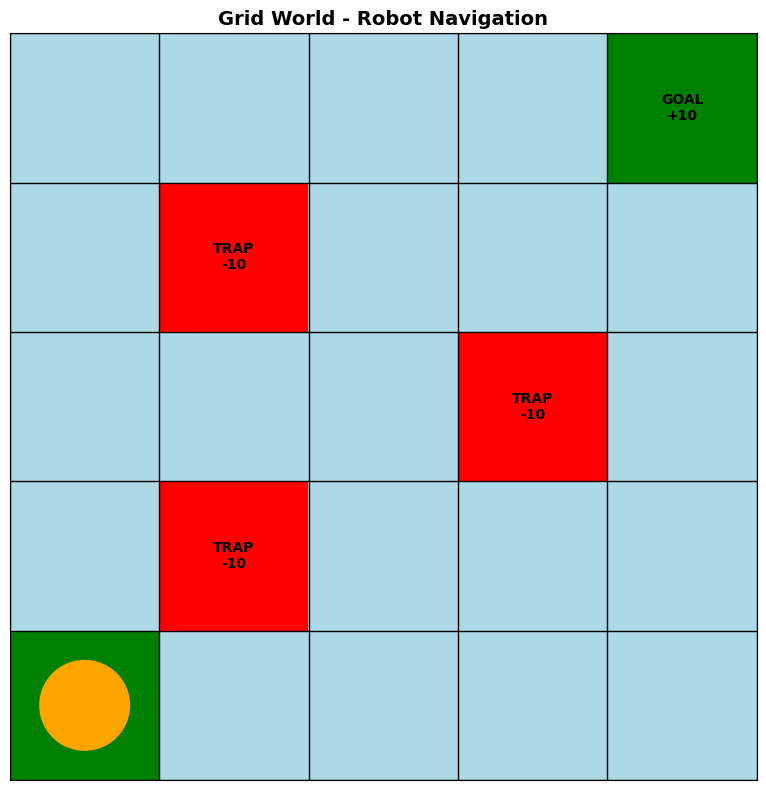

Step 1:
  Current state: (0, 0)
  Q-values: [Up: -2.41, Down: -3.58, Left: -2.82, Right: -0.43]
  Chosen action: Right
  Reward: -1, New state: (0, 1)
  Total reward so far: -1



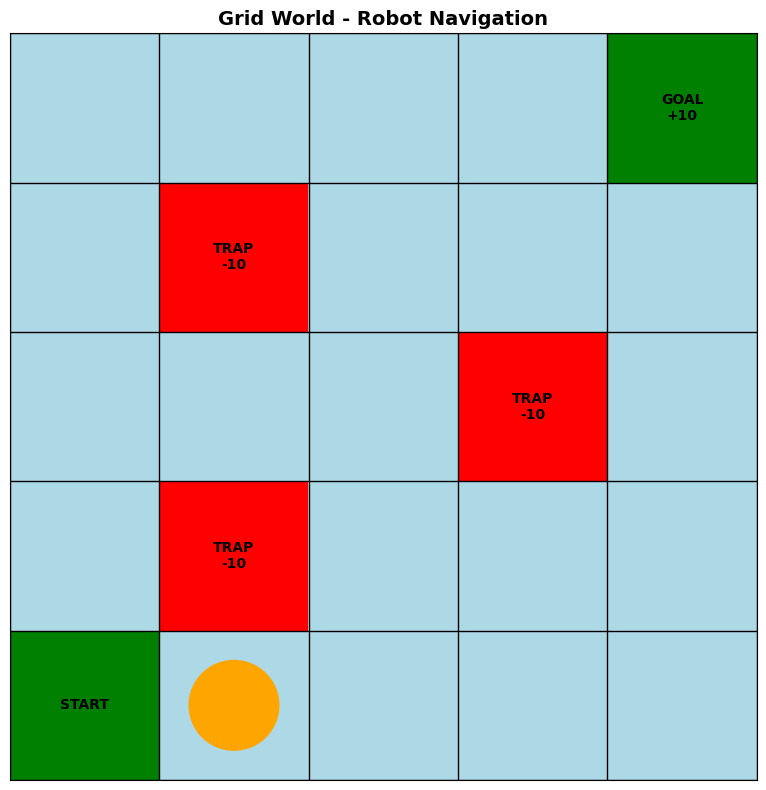

Step 2:
  Current state: (0, 1)
  Q-values: [Up: -1.15, Down: -9.92, Left: -1.85, Right: 0.63]
  Chosen action: Right
  Reward: -1, New state: (0, 2)
  Total reward so far: -2



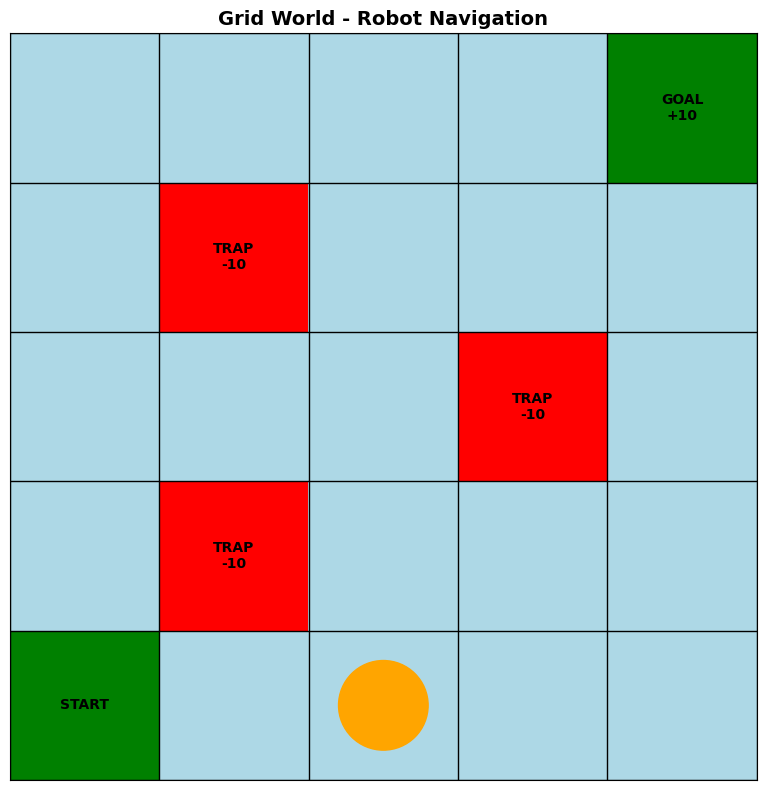

Step 3:
  Current state: (0, 2)
  Q-values: [Up: -0.44, Down: 1.81, Left: -2.26, Right: -2.18]
  Chosen action: Down
  Reward: -1, New state: (1, 2)
  Total reward so far: -3



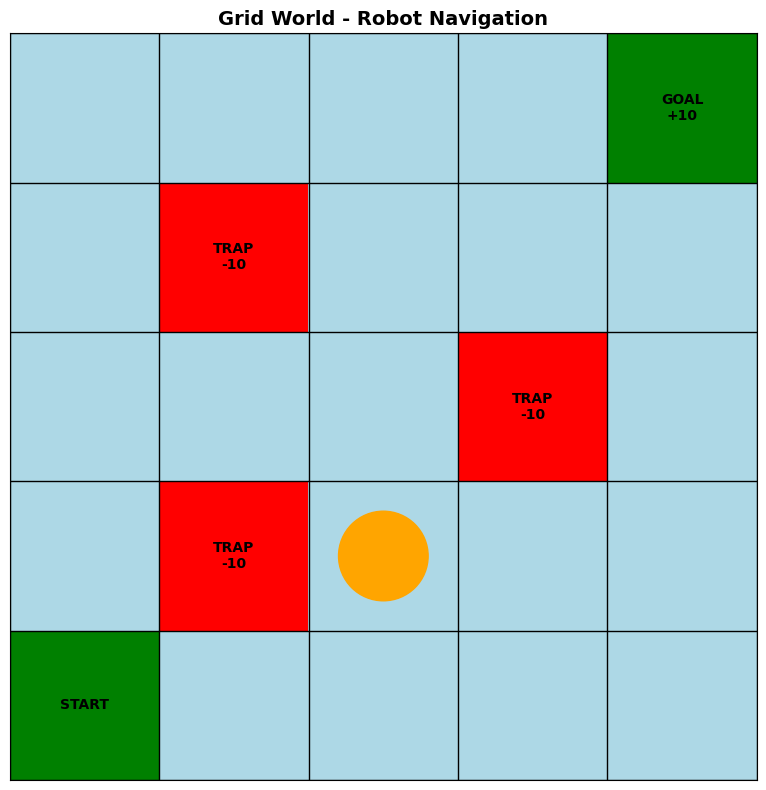

Step 4:
  Current state: (1, 2)
  Q-values: [Up: -0.62, Down: 3.12, Left: -9.53, Right: -0.19]
  Chosen action: Down
  Reward: -1, New state: (2, 2)
  Total reward so far: -4



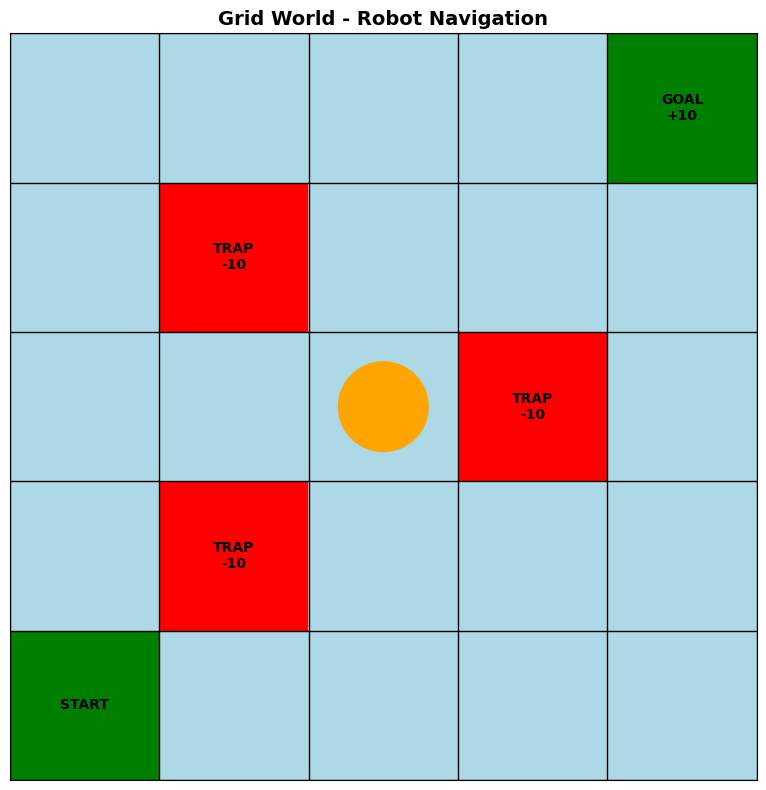

Step 5:
  Current state: (2, 2)
  Q-values: [Up: 0.68, Down: 4.58, Left: -0.50, Right: -9.35]
  Chosen action: Down
  Reward: -1, New state: (3, 2)
  Total reward so far: -5



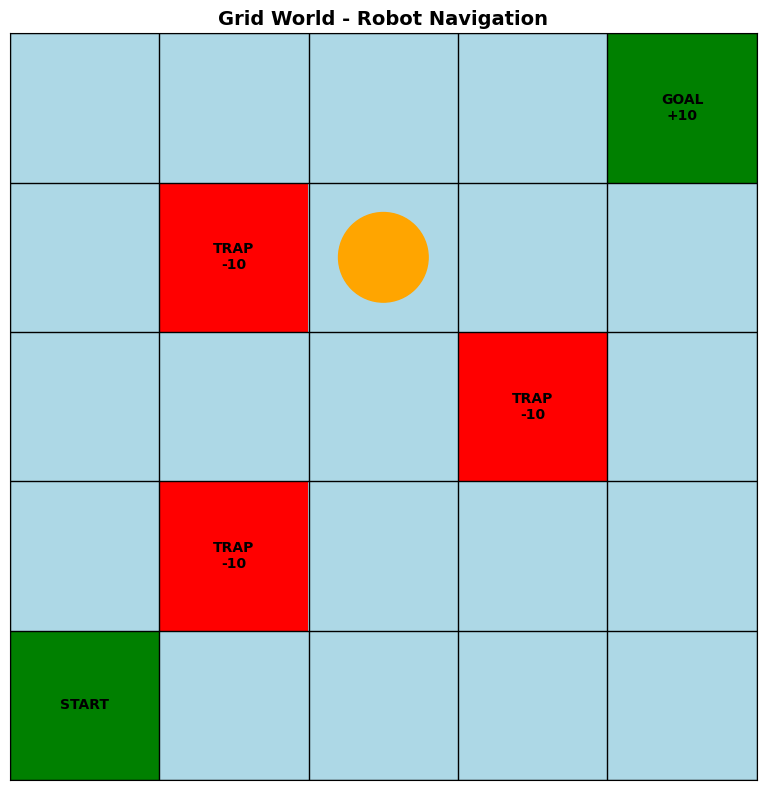

Step 6:
  Current state: (3, 2)
  Q-values: [Up: 2.08, Down: 4.59, Left: -8.50, Right: 6.20]
  Chosen action: Right
  Reward: -1, New state: (3, 3)
  Total reward so far: -6



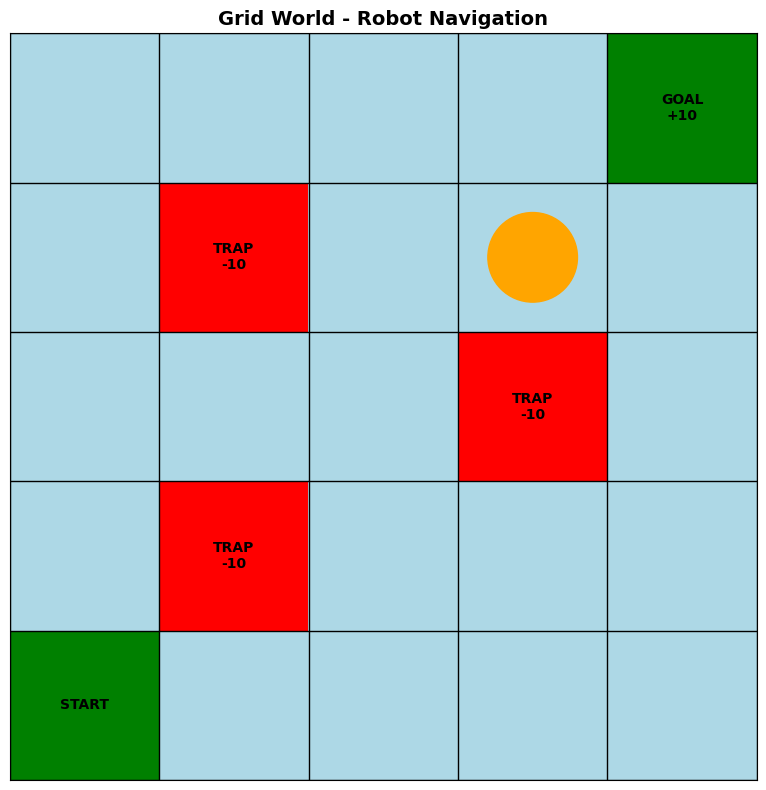

Step 7:
  Current state: (3, 3)
  Q-values: [Up: -8.15, Down: 8.00, Left: 3.35, Right: 5.19]
  Chosen action: Down
  Reward: -1, New state: (4, 3)
  Total reward so far: -7



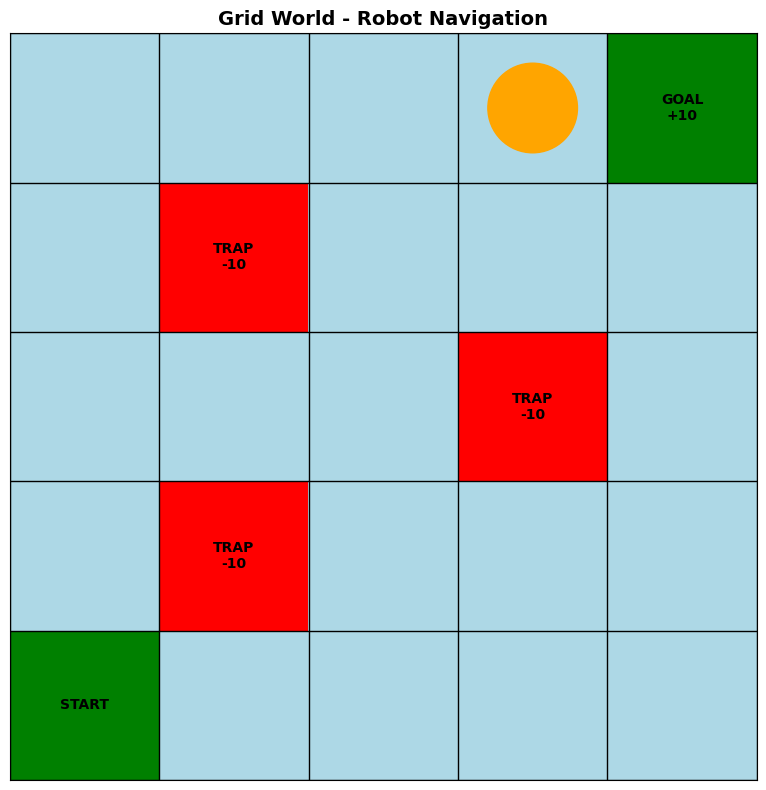

Step 8:
  Current state: (4, 3)
  Q-values: [Up: 5.20, Down: 6.98, Left: 5.37, Right: 10.00]
  Chosen action: Right
  Reward: 10, New state: (4, 4)
  Total reward so far: 3
  🎉 SUCCESS! Reached the goal!

Episode completed in 8 steps with total reward: 3


(3, 8)

In [ ]:
def demonstrate_episode(agent, env, show_q_values=False):
    """Demonstrate one episode step by step"""
    state = env.reset()
    total_reward = 0
    step = 0
    
    # Disable exploration for demonstration
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    print("Step-by-step demonstration:")
    print(f"Starting at position {state}")
    print()
    
    # Show initial state
    env.visualize(agent.q_table if show_q_values else None, show_q_values)
    
    while step < 20:  # Limit to 20 steps for visualization
        # Show Q-values for current state
        row, col = state
        q_values = agent.q_table[row, col]
        action = agent.choose_action(state)
        
        print(f"Step {step + 1}:")
        print(f"  Current state: {state}")
        print(f"  Q-values: [Up: {q_values[0]:.2f}, Down: {q_values[1]:.2f}, "
              f"Left: {q_values[2]:.2f}, Right: {q_values[3]:.2f}]")
        print(f"  Chosen action: {env.actions[action]}")
        
        # Take action
        next_state, reward, done = env.step(action)
        total_reward += reward
        step += 1
        
        print(f"  Reward: {reward}, New state: {next_state}")
        print(f"  Total reward so far: {total_reward}")
        
        if done:
            if next_state == env.goal_pos:
                print("  🎉 SUCCESS! Reached the goal!")
            else:
                print("  💥 FAILURE! Hit a trap!")
            break
        
        print()
        state = next_state
        
        # Show updated state
        env.visualize(agent.q_table if show_q_values else None, show_q_values)
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    print(f"\nEpisode completed in {step} steps with total reward: {total_reward}")
    return total_reward, step

# Run demonstration
print("=" * 60)
print("DEMONSTRATION: Watching the trained agent navigate")
print("=" * 60)
demonstrate_episode(agent, env, show_q_values=False)

## Summary and Key Insights

### What We Learned

1. **Q-Learning Basics**: The agent learned to estimate the "quality" (Q-value) of taking each action in each state.

2. **Exploration vs Exploitation**: The epsilon-greedy strategy balanced exploring new actions with exploiting known good actions.

3. **Reward Shaping**: The combination of goal rewards (+10), trap penalties (-10), and step costs (-1) guided the agent toward efficient paths.

4. **Convergence**: Over time, the agent's policy stabilized, and it learned to consistently reach the goal while avoiding traps.

### Key Q-Learning Components

- **Q-Table**: Stores the learned values for each state-action pair
- **Update Rule**: $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$
- **Exploration Strategy**: Epsilon-greedy policy for balancing exploration and exploitation
- **Learning Rate (α)**: Controls how quickly the agent updates its knowledge
- **Discount Factor (γ)**: Determines the importance of future rewards

### Real-World Applications

This grid world problem is simplified, but the same Q-learning principles apply to:

- **Robot Navigation**: Path planning in warehouses, autonomous vehicles
- **Game Playing**: Board games, video games
- **Resource Management**: Inventory control, energy management
- **Process Control**: Industrial automation, chemical processes

### Next Steps

To extend this tutorial, you could:

1. **Modify the Environment**: Add moving obstacles, multiple goals, or different reward structures
2. **Try Different Algorithms**: SARSA, Double Q-Learning, or Deep Q-Networks (DQN)
3. **Experiment with Parameters**: Different learning rates, discount factors, or exploration strategies
4. **Add Complexity**: Larger grids, continuous states, or partial observability